$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield



\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    1\\
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have: 

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0 \\ 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with 

\begin{equation}
F = \begin{bmatrix} 
0 &0 & 0 & 0 & 0 & 0\\  
0 & 0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & \lambda & 0 & 0\\
0 &0 & 0 & 0 & \mu & 0 \\
0 &0 & 0 & 0 & 0 & 2 \lambda\\
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
-\frac{1}{\lambda}& 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & -2c & 0 & 0\\
0 & 0 & 0 & 2 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 &  0 & 0 & 0 & 0\\
 -\frac{1}{\mu} & -\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & \frac{1}{\lambda} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [1]:
import numpy as np
import sys
sys.path.append('../../')

# Define experiment parameters

In [2]:
from core.dynamics import RoboticDynamics, ConfigurationDynamics

class KoopPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q = x[:int(n/2)]
        q_d = self.xd[:int(n/2)]

        return  q - q_d

    def derivative(self, x, t):
        q_dot = x[int(n/2):]
        q_dot_d = self.xd[int(n/2):]

        return q_dot - q_dot_d

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
sys_name = 'bilinearizable_sys'
system = FiniteDimKoopSys(lambd, mu, c)

In [3]:
from koopman_core.dynamics import LinearLiftedDynamics

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
dt = 1e-2
linearized_sys = LinearLiftedDynamics(A_lin, B_lin, np.eye(n), lambda x: x)

# Collect data for learning 

In [4]:
import scipy as sc
import os

q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_lin, B_lin, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_lin.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection

# Data collection parameters:
collect_data = False
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_train = 100                                                      # Number of trajectories to execute, data collection
n_traj_val = int(0.2*n_traj_train)
noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([1., 1., 1., 1.])                                   # State constraints, trajectory generation
xmin = -xmax
umax = np.array([10., 10.])                                         # Actuation constraint, trajectory generation
umin = -umax
x0_max = xmax/2                                                     # Initial value limits
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = 'examples/'                                           # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot
directory = os.path.abspath("")                                     # Path to save learned models

In [5]:
from koopman_core.util import run_experiment
import dill

if collect_data:
    xs_train, us_train, t_train = run_experiment(system, n, n_traj_train, n_pred_dc, t_eval, x0_max, plot_experiment_data=True,
                                      m=m, K_p=K_dc_p, K_d=K_dc_d, noise_var=noise_var)
    xs_val, us_val, t_val = run_experiment(system, n, n_traj_val, n_pred_dc, t_eval, x0_max,
                                      m=m, K_p=K_dc_p, K_d=K_dc_d, noise_var=noise_var)

    data_list = [xs_train, us_train, t_train, n_traj_train, xs_val, us_val, t_val, n_traj_val]
    outfile = open(directory + '/data/' + sys_name + '_data.pickle', 'wb')
    dill.dump(data_list, outfile)
    outfile.close()
else:
    infile = open(directory + '/data/' + sys_name + '_data.pickle', 'rb')
    xs_train, us_train, t_train, n_traj_train, xs_val, us_val, t_val, n_traj_val = dill.load(infile)
    infile.close()

# Learn Koopman-based models of the dynamics

### Learn bilinear EDMD model

In [6]:
#Bilinear EDMD parameters:                                           
alpha_bedmd = 2.4e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [7]:
from sklearn import preprocessing, linear_model
from koopman_core.learning import BilinearEdmd
from koopman_core.dynamics import BilinearLiftedDynamics

bedmd_features = preprocessing.PolynomialFeatures(2)
bedmd_features.fit(np.zeros((1,n)))
n_lift_bedmd = bedmd_features.transform((np.zeros((1,n)))).shape[1]

C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: bedmd_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random')
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
#standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)
standardizer_bedmd = None

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_train, optimizer_bedmd, cv=cv_bedmd, 
                           standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
X_bedmd, y_bedmd = model_bedmd.process(xs_train, us_train, np.tile(t_train,(n_traj_train,1)), downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, 
                                   model_bedmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)

### Learn Koopman DNN model

In [8]:
import dill, os, torch

load_tuned_params = False

if load_tuned_params:
    infile = open(os.path.abspath('') + '/data/analytic_koop_sys_best_params.pickle', 'rb')
    best_config, val_loss, test_loss, open_loop_mse, open_loop_std = dill.load(infile)
    infile.close()

else:
    net_params = {}
    net_params['state_dim'] = n
    net_params['ctrl_dim'] = m
    net_params['encoder_hidden_width'] = 100
    net_params['encoder_hidden_depth'] = 1
    net_params['encoder_output_dim'] = 1
    net_params['optimizer'] = 'adam'
    net_params['activation_type'] = 'relu'
    net_params['lr'] = 1e-2
    net_params['epochs'] = 500
    net_params['batch_size'] = 256
    net_params['lin_loss_penalty'] = 1e-1
    net_params['l2_reg'] = 0
    net_params['l1_reg'] = 0
    net_params['first_obs_const'] = True
    net_params['override_kinematics'] = True # TODO: Fix override kin... 
    net_params['dt'] = dt

print(net_params)

{'state_dim': 4, 'ctrl_dim': 2, 'encoder_hidden_width': 100, 'encoder_hidden_depth': 1, 'encoder_output_dim': 1, 'optimizer': 'adam', 'activation_type': 'relu', 'lr': 0.01, 'epochs': 500, 'batch_size': 256, 'lin_loss_penalty': 0.1, 'l2_reg': 0, 'l1_reg': 0, 'first_obs_const': True, 'override_kinematics': True, 'dt': 0.01}


In [9]:
from koopman_core.learning import KoopDnn, KoopmanNetCtrl
from koopman_core.util import fit_standardizer

standardizer_x_kdnn = fit_standardizer(xs_train, preprocessing.StandardScaler())
#standardizer_x_kdnn = None
standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler())
n_tot = n + net_params['encoder_output_dim'] + int(net_params['first_obs_const'])

net = KoopmanNetCtrl(net_params, standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)
model_koop_dnn = KoopDnn(net)
model_koop_dnn.set_datasets(xs_train, t_train, u_train=us_train, x_val=xs_val, u_val=us_val, t_val=t_val)
model_koop_dnn.model_pipeline(net_params)
model_koop_dnn.construct_koopman_model()
sys_koop_dnn = BilinearLiftedDynamics(n_tot, m, model_koop_dnn.A, model_koop_dnn.B, model_koop_dnn.C, 
                                      model_koop_dnn.basis_encode, continuous_mdl=False, dt=dt, 
                                      standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)

Epoch   1: train loss: 1056.05395508, validation loss: 1001.26232147
Epoch   2: train loss: 984.04943848, validation loss: 945.04153061
Epoch   3: train loss: 923.16809082, validation loss: 894.25643921
Epoch   4: train loss: 870.64001465, validation loss: 839.70886993
Epoch   5: train loss: 820.98797607, validation loss: 792.99705505
Epoch   6: train loss: 774.46490479, validation loss: 748.93698883
Epoch   7: train loss: 728.45782471, validation loss: 699.77265930
Epoch   8: train loss: 687.15802002, validation loss: 663.08065414
Epoch   9: train loss: 644.83386230, validation loss: 623.49240494
Epoch  10: train loss: 606.18682861, validation loss: 584.33798599
Epoch  11: train loss: 570.79571533, validation loss: 550.02181244
Epoch  12: train loss: 535.59777832, validation loss: 516.75147438
Epoch  13: train loss: 502.72775269, validation loss: 484.71827698
Epoch  14: train loss: 472.72482300, validation loss: 455.32818985
Epoch  15: train loss: 445.34503174, validation loss: 426.57

Epoch 129: train loss: 0.01098652, validation loss: 0.01323472
Epoch 130: train loss: 0.01047761, validation loss: 0.01421682
Epoch 131: train loss: 0.00811994, validation loss: 0.01087226
Epoch 132: train loss: 0.00733070, validation loss: 0.01192433
Epoch 133: train loss: 0.00615512, validation loss: 0.00946370
Epoch 134: train loss: 0.00735780, validation loss: 0.02278075
Epoch 135: train loss: 0.00670526, validation loss: 0.01585799
Epoch 136: train loss: 0.00887256, validation loss: 0.00871714
Epoch 137: train loss: 0.00662381, validation loss: 0.01050425
Epoch 138: train loss: 0.00934700, validation loss: 0.01429217
Epoch 139: train loss: 0.01026348, validation loss: 0.00867781
Epoch 140: train loss: 0.00586091, validation loss: 0.00840832
Epoch 141: train loss: 0.00645168, validation loss: 0.01292992
Epoch 142: train loss: 0.00660574, validation loss: 0.01348882
Epoch 143: train loss: 0.01092445, validation loss: 0.01223763
Epoch 144: train loss: 0.00595941, validation loss: 0.0

Epoch 260: train loss: 0.00131010, validation loss: 0.00143188
Epoch 261: train loss: 0.00151441, validation loss: 0.00268650
Epoch 262: train loss: 0.00134272, validation loss: 0.00160613
Epoch 263: train loss: 0.00151018, validation loss: 0.00195735
Epoch 264: train loss: 0.00127433, validation loss: 0.00150900
Epoch 265: train loss: 0.00123119, validation loss: 0.00108152
Epoch 266: train loss: 0.00146597, validation loss: 0.00178938
Epoch 267: train loss: 0.00138754, validation loss: 0.00151480
Epoch 268: train loss: 0.00134431, validation loss: 0.00156968
Epoch 269: train loss: 0.00135463, validation loss: 0.00189046
Epoch 270: train loss: 0.00149096, validation loss: 0.00151630
Epoch 271: train loss: 0.00120947, validation loss: 0.00102501
Epoch 272: train loss: 0.00117387, validation loss: 0.00121060
Epoch 273: train loss: 0.00121598, validation loss: 0.00201045
Epoch 274: train loss: 0.00138811, validation loss: 0.00134017
Epoch 275: train loss: 0.00176342, validation loss: 0.0

Epoch 391: train loss: 0.00083934, validation loss: 0.00062475
Epoch 392: train loss: 0.00071270, validation loss: 0.00064156
Epoch 393: train loss: 0.00065033, validation loss: 0.00051405
Epoch 394: train loss: 0.00066861, validation loss: 0.00055445
Epoch 395: train loss: 0.00067814, validation loss: 0.00053682
Epoch 396: train loss: 0.00063032, validation loss: 0.00046313
Epoch 397: train loss: 0.00063465, validation loss: 0.00060413
Epoch 398: train loss: 0.00064550, validation loss: 0.00064642
Epoch 399: train loss: 0.00072120, validation loss: 0.00049763
Epoch 400: train loss: 0.00062418, validation loss: 0.00067221
Epoch 401: train loss: 0.00066264, validation loss: 0.00057195
Epoch 402: train loss: 0.00062489, validation loss: 0.00090653
Epoch 403: train loss: 0.01625406, validation loss: 0.00481820
Epoch 404: train loss: 0.00250287, validation loss: 0.00163294
Epoch 405: train loss: 0.00136703, validation loss: 0.00132000
Epoch 406: train loss: 0.00132625, validation loss: 0.0

In [10]:
sys_koop_dnn.A

array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  1.1108225e-02,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00,
         1.0557983e-02,  0.0000000e+00],
       [ 1.1786604e-03, -2.1383153e-06,  7.5332572e-08,  1.0030043e+00,
        -1.9111917e-06, -3.2882392e-06],
       [ 1.7105874e-04, -9.6479111e-04, -2.9694183e-05,  4.9421778e-05,
         1.0020913e+00, -8.8093448e-03],
       [-3.4860490e-04, -1.1059882e-03, -8.4219777e-05, -1.4413564e-03,
         5.1106745e-06,  9.9100000e-01]], dtype=float32)

# Evaluate open-loop prediction performance

In [11]:
# Prediction performance evaluation parameters:
folder_plots = 'figures/'                                          # Path to save plots
n_traj_ol = 50                                                     # Number of trajectories to execute, open loop

In [12]:
from koopman_core.util import evaluate_ol_pred
from tabulate import tabulate
import random as rand

xs_ol, us_ol, t_ol = run_experiment(system, n, n_traj_ol, n_pred_dc, t_eval, x0_max,
                                      m=m, K_p=K_dc_p, K_d=K_dc_d, noise_var=noise_var)

mdl_lst = [sys_koop_dnn, sys_bedmd]
mdl_names = ['Koop DNN', 'bEDMD']
error, mse, std = [], [], []

for sys in mdl_lst:
    err_tmp, mse_tmp, std_tmp = evaluate_ol_pred(sys, xs_ol, t_eval, us=us_ol)
    error.append(err_tmp)
    mse.append(mse_tmp)
    std.append(std_tmp)
    
print('\nOpen loop performance statistics:')
table_data = []
for name, mse_mdl, std_mdl in zip(mdl_names, mse, std):
    table_data.append([name, "{:.5f}".format(mse_mdl), "{:.5f}".format(std_mdl)])

print(tabulate(table_data, 
               headers=['Mean squared error', 'Standard deviation']))


Open loop performance statistics:
            Mean squared error    Standard deviation
--------  --------------------  --------------------
Koop DNN               1e-05                 0.00329
bEDMD                  0.00019               0.01362


<Figure size 864x432 with 0 Axes>

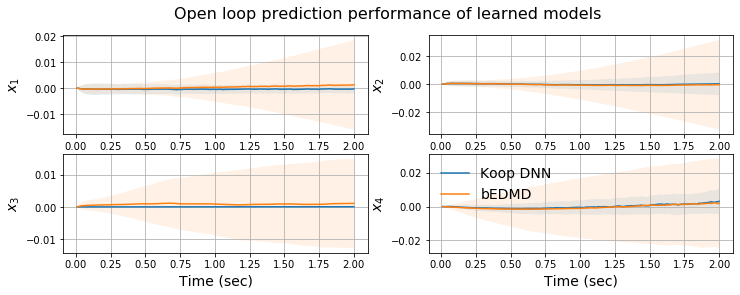

In [13]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 14
y_lim_gain = 1.2
row = 2
col = n/row

#Plot open loop results:
plt.figure(figsize=(figwidth,4))
axs = [plt.subplot(row,col,jj+1) for jj in range(n)]

for ii, err in enumerate(error):
    err_mean = np.mean(err, axis=0)
    err_std = np.std(err, axis=0)
    
    for jj in range(n):
        axs[jj].plot(t_eval[1:], err_mean[:,jj], label=mdl_names[ii])
        axs[jj].fill_between(t_eval[1:], err_mean[:,jj]-err_std[:,jj], err_mean[:,jj]+err_std[:,jj], alpha=0.1)

for jj in range(n):
    axs[jj].grid()
    axs[jj].set_xlabel('Time (sec)', fontsize=fs)
    axs[jj].set_ylabel('$x_'+ str(jj+1) + '$', fontsize=fs)

plt.legend(frameon=False, fontsize=fs)
stitle=plt.suptitle('Open loop prediction performance of learned models', fontsize=fs+2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig(folder_plots + 'koop_sys_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(stitle,), bbox_inches="tight")
plt.show()

In [14]:
print(standardizer_u_kdnn.mean_)
print(standardizer_u_kdnn.scale_)
print(standardizer_x_kdnn.mean_)
print(standardizer_x_kdnn.scale_)

[0.0223093  0.00944786]
[5.44863724 5.43992453]
[ 0.01007821 -0.00539606 -0.01089513  0.00437488]
[0.14561805 0.16455691 0.16175582 0.17373891]
